SPDX-License-Identifier: Apache-2.0
Copyright (c) 2023, Rahul Unnikrishnan Nair <rahul.unnikrishnan.nair@intel.com>


# Text to SQL Generation: Fine-Tuning LLMs with QLoRA on Intel

Hello and welcome! In this Jupyter Notebook, we will walkthrough the process of fine-tuning a large language model (LLM) to improve its capabilities in generating SQL queries from natural language input. The notebook is suitable for AI engineers and practitioners looking to tune LLMs for specialized tasks such as Text-to-SQL conversions.

### What you will learn with this Notebook

- Fine-tune a Language Model with either a pre-existing dataset or a custom dataset tailored to your needs on Intel Hw.
- Gain insights into the fine-tuning process, including how to manipulate various training parameters to optimize your model's performance.
- Test different configurations and observe the results in real-time.

### Hardware Compatibility

- The notebook utilizes both 4th Generation Intel® Xeon® Scalable Processors (cpu) and Intel® Data Center GPU Max Series 1100 (xpu).

### Fine-Tuning with QLoRA: Balancing Memory Efficiency and Adaptability

We leverage the QLoRA methodology for fine-tuning, enabling the loading and refinement of LLMs within the constraints of available GPU memory. QLoRA, which stands for Quantized Low Rank Adapter, achieves this by applying a clever combination of weight quantization and adapter-based finetuning.

The core idea behind QLoRA is to reduce the memory footprint by quantizing the weights of a pre-trained model—compressing them down to a fraction of their original size. This quantization allows us to operate with models that would otherwise exceed our hardware limits. During the fine-tuning process, we optimize only the adapter parameters, which are low-rank matrices specifically designed to update the model for our target task without the need to retrain the entire network. This selective training approach also contributes to computational efficiency, as it narrows down the number of trainable parameters.

What is the Big Picture?

I would like you to consider reparameterization using QLoRA, where we inject LoRA weights and solely train those, instead of the entire layer, when fine-tuning. This method serves as a solution to obtain task-specific models. Expanding on this, you can maintain a collection of LoRA adapters for various tasks and utilize the same foundational model, choosing the appropriate set of adapter weights from your library based on the task. Below, on the left, is the overview of reparameterization we implement with LoRA(with Quantization), where a smaller set of matrices is trained specifically for the task. On the right, you can see a high-level view of how you can employ a hub-and-spoke model for LLM deployment, where the hub is the Foundation model and spokes are LoRA adapters.

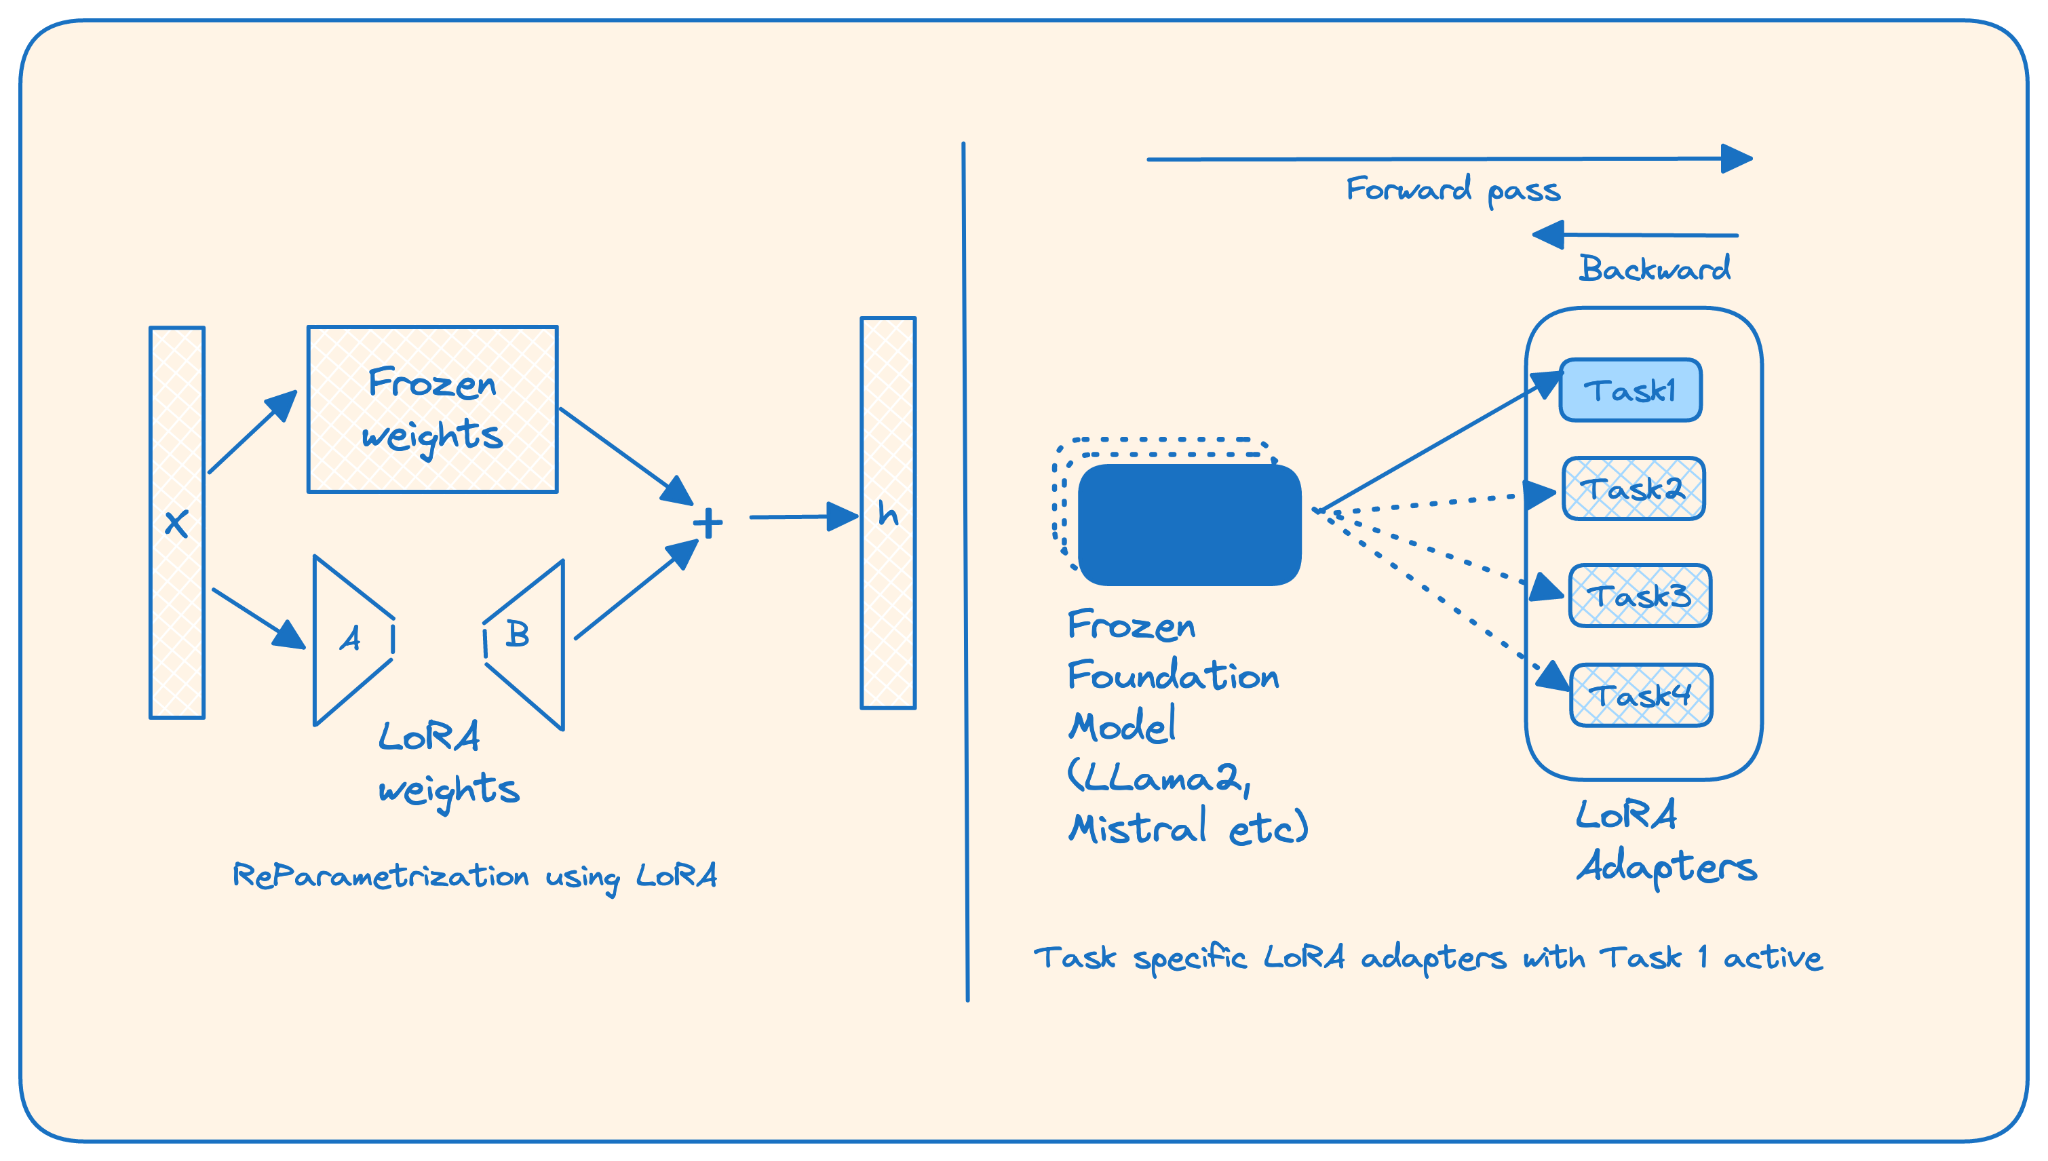

Through this technique, we can adapt a model to generate SQL queries from natural language with minimal overhead. The BigDL library, Hugging Face Transformers and the peft library provide the necessary tools for this process, facilitating the fine-tuning of language models in a way that is both resource-conscious and effective.


Let's begin our journey into fine-tuning a model that can adeptly translate natural language queries into SQL statements.


## Initialization

Let's first install and import all the necessary libraries required for the fine-tuning process.


In [ ]:
import site
import subprocess
import sys
import uuid
from pathlib import Path
import pkg_resources


def get_python_version():
    return "python" + ".".join(map(str, sys.version_info[:2]))


def is_package_installed(pkg_name):
    try:
        pkg_resources.get_distribution(pkg_name)
        return True
    except pkg_resources.DistributionNotFound:
        return False


def set_local_bin_path():
    local_bin = str(Path.home() / ".local" / "bin")
    local_site_packages = str(
        Path.home() / ".local" / "lib" / get_python_version() / "site-packages"
    )
    sys.path.append(local_bin)
    sys.path.insert(0, site.getusersitepackages())
    sys.path.insert(0, sys.path.pop(sys.path.index(local_site_packages)))


def install_pkgs(pkgs_dict=None):
    set_local_bin_path()
    uniq_dir = f"pycache_{uuid.uuid4().hex}"
    cache_dir = str(Path("/tmp") / uniq_dir)
    if cache_dir:
        Path(cache_dir).mkdir(parents=True, exist_ok=True)
    if pkgs_dict is not None:
        for pkg_name, pkg_url in pkgs_dict.items():
            if is_package_installed(pkg_name):
                print(f'Package "{pkg_name}" is already installed. Skipping.')
                continue
            cmd = [
                sys.executable,
                "-m",
                "pip",
                "install",
                "--upgrade",
                "--cache-dir",
                cache_dir,
            ] + pkg_url.split()
            for attempt in range(3):
                try:
                    print(f'Attempting to install: "{pkg_name}", please wait...')
                    subprocess.run(
                        cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE
                    )
                    print(f'"{pkg_name}" installed successfully.')
                    break
                except subprocess.CalledProcessError as e:
                    print(
                        f'Attempt {attempt + 1}: Error installing "{pkg_name}": {e.stderr.decode().strip()}'
                    )
                    if "OSError" in e.stderr.decode() and attempt < 2:
                        print("Retrying due to OSError...")
                    else:
                        print(f'Final attempt failed for "{pkg_name}".')
                        break
    if cache_dir:
        subprocess.run(["rm", "-rf", cache_dir], check=False)


pkgs_dict = {
    "bigdl-llm": "--pre --upgrade bigdl-llm[xpu]==2.4.0b20231116 -f https://developer.intel.com/ipex-whl-stable-xpu",
    "peft": "peft==0.5.0",
    "transformers": "transformers==4.34.0",
    "accelerate": "accelerate==0.23.0",
    "datasets": "datasets",
    "wandb": "wandb",
}

install_pkgs(pkgs_dict)

In [ ]:
import logging
import os
import sys
from math import ceil
from typing import Optional, Tuple
import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, module="intel_extension_for_pytorch"
)
warnings.filterwarnings(
    "ignore", category=UserWarning, module="torchvision.io.image", lineno=13
)
warnings.filterwarnings("ignore", message="You are using the default legacy behaviour")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Parameter.*")
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="This implementation of AdamW is deprecated",
)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["NUMEXPR_MAX_THREADS"] = "28"
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("bigdl").setLevel(logging.ERROR)


import torch
import intel_extension_for_pytorch as ipex
from datasets import load_dataset
from datasets import Dataset
from bigdl.llm.transformers import AutoModelForCausalLM
from bigdl.llm.transformers.qlora import (
    get_peft_model,
    prepare_model_for_kbit_training as prepare_model,
)
from peft import LoraConfig
from bigdl.llm.transformers.qlora import PeftModel
import transformers
from transformers import (
    DataCollatorForSeq2Seq,
    LlamaTokenizer,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

transformers.logging.set_verbosity_error()

## Note on Model Storage Management

A set of LLM foundation models are supported out-of-the-box as stated below `BASE_MDOELS` dictionary. However, if you're interested in experimenting with additional models, consider the following guidelines:

- **Storage Limitations:** Every user has a default free storage quota. You'll need to ensure that you have enough available space for the models you want to use, especially if your local directory is already storing data.
- **Model Supported by PEFT:** If the model you're interested in is supported by the `peft` library by default, the necessary LoRA target modules are predefined and can be found in the [PEFT repository](https://github.com/huggingface/peft/blob/main/src/peft/utils/other.py#L434).
- **Using Custom Models:** For models not natively supported by `peft`, you'll need to manually set the LoRA target modules in the `LoraConfig`. As an example, for llama models, the relevant target modules would be: `["q_proj", "k_proj", "v_proj", "o_proj"]`.
- **Checking and Retrieving Disk Space:** To check the available disk space where Hugging Face models are cached, use the Python function. If you need to free up space, you can delete the cache directory, but be aware that this will remove all downloaded models and they will have to be re-downloaded when needed next time.
- Also reset the variable in the **Model Configuration** cell to `MODEL_CACHE_PATH = "~/"`

### Python Function to Check Disk Space

```python
# Function to check available disk space in the Hugging Face cache directory
import os
import shutil

def check_disk_space(path="~/.cache/huggingface/"):
    abs_path = os.path.expanduser(path)
    total, used, free = shutil.disk_usage(abs_path)
    print(f"Total: {total // (2**30)} GiB")
    print(f"Used: {used // (2**30)} GiB")
    print(f"Free: {free // (2**30)} GiB")

# Example usage
check_disk_space()
```


## Tailoring Your Model Configuration

Welcome to the heart of customization in model fine-tuning. As you embark on this practical journey, you have a suite of base models at your disposal. Each has unique strengths, and the choice depends on your specific finetuning goals.

- **Your Model Options**: Within the `BASE_MODELS`, you’ll find options ranging from the nimble
  `open_llama_7b_v2` to the more expansive `Llama-2-13b-hf`, and specialized variants like `CodeLlama-7b-hf`.
  Feel free to switch between these models to discover which one aligns best with your objectives.

- **Dataset**: We will be using `b-mc2/sql-create-context` dataset from Huggingface datasets, that encompasses 78,577 examples, including natural language queries, SQL CREATE TABLE statements, and corresponding SQL queries. This dataset, extending from WikiSQL and Spider, is designed with text-to-SQL models in mind. It provides the structure needed for models to understand and generate accurate SQL statements. More details on the dataset can be found [here](https://huggingface.co/datasets/b-mc2/sql-create-context).
- **LoRA Parameters - Your Knobs to Turn**:
  - `r` (Rank): This is a key factor in how finely your model can adapt. A higher rank can grasp more
    complex nuances, while a lower rank ensures a leaner memory footprint.
  - `lora_alpha` (Scaling Factor): Think of this as the volume control for the LoRA adapters’ influence
    on your model. Adjusting `lora_alpha` helps you fine-tune the balance between adaptation and preserving
    the integrity of the pre-trained weights.
  - `target_modules`: You decide which parts of the transformer model to enhance with LoRA adapters,
    directly impacting how your model interprets and generates language.
  - `lora_dropout`: A parameter that helps your model stay robust against overfitting. You can experiment
    with different rates to achieve the best generalization.
  - `bias`: Tweak the bias configurations to see their effect on your model’s learning dynamics.

This notebook is set to start with `open_llama_7b_v2` as the default model, striking a balance suitable for a wide range of tasks. However, this journey is yours, and the real power lies with you to explore and fine-tune these settings to perfection on your chosen hardware. To use models like Llama 2, you will have to accept the usage policy as stipulated [here](https://ai.meta.com/llama/use-policy/)


In [ ]:
BASE_MODELS = {
    #"0": "openlm-research/open_llama_3b_v2",  # https://huggingface.co/openlm-research/open_llama_3b_v2
    #"1": "openlm-research/open_llama_13b",  # https://huggingface.co/openlm-research/open_llama_13b
    "1": "openlm-research/open_llama_7b_v2",  # https://huggingface.co/openlm-research/open_llama_7b_v2
    "2": "NousResearch/Nous-Hermes-Llama-2-7b",  # https://huggingface.co/NousResearch/Nous-Hermes-llama-2-7b
    "3": "NousResearch/Llama-2-7b-chat-hf",  # https://huggingface.co/NousResearch/Llama-2-7b-chat-hf
    "4": "NousResearch/Llama-2-13b-hf",  # https://huggingface.co/NousResearch/Llama-2-13b-hf
    "5": "NousResearch/CodeLlama-7b-hf",  # https://huggingface.co/NousResearch/CodeLlama-7b-hf
    "6": "Phind/Phind-CodeLlama-34B-v2",  # https://huggingface.co/Phind/Phind-CodeLlama-34B-v2
}
BASE_MODEL = BASE_MODELS["1"]
DATA_PATH = "b-mc2/sql-create-context"
MODEL_PATH = "./final_model"
ADAPTER_PATH = "./lora_adapters"
DEVICE = torch.device("xpu" if torch.xpu.is_available() else "cpu")
LORA_CONFIG = LoraConfig(
    r=16,  # rank
    lora_alpha=32,  # scaling factor
    target_modules=["q_proj", "k_proj", "v_proj"], 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
MODEL_CACHE_PATH = "/home/common/data/Big_Data/GenAI/llm_models"

print("=" * 80)
print(f"Using Device: {DEVICE}")
print(f"Final model will be saved to: {MODEL_PATH}")
print(f"LoRA adapters will be saved to: {ADAPTER_PATH}")
print(f"Finetuning Model: {BASE_MODEL}")
print(f"Using dataset from: {DATA_PATH}")
print(f"Model cache: {MODEL_CACHE_PATH}")
print("=" * 80)

## Prompt Engineering for Text-to-SQL Conversion

In the realm of fine-tuning language models for specialized tasks, the design of the prompt is pivotal. The function `generate_prompt_sql` plays a crucial role in this process, particularly for the task of converting natural language questions into SQL queries.The function encapsulates the input question, the relevant database context, and the expected output in a structured and concise manner.


In [ ]:
def generate_prompt_sql(input_question, context, output=""):
    """
    Generates a prompt for fine-tuning the LLM model for text-to-SQL tasks.

    Parameters:
        input_question (str): The input text or question to be converted to SQL.
        context (str): The schema or context in which the SQL query operates.
        output (str, optional): The expected SQL query as the output.

    Returns:
        str: A formatted string serving as the prompt for the fine-tuning task.
    """
    return f"""You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables. 

You must output the SQL query that answers the question.

### Input:
{input_question}

### Context:
{context}

### Response:
{output}"""

## Model Loading and Configuration

When initializing the `FineTuner` below, we load the base model specified by the `base_model_id`. Crucially, we use the `load_in_low_bit` parameter made possible by the BigDL library with the value "nf4", which allows the model to load in a 4-bit format, significantly reducing memory footprint while maintaining performance. The LoRA adapters is also set to use a `torch_dtype` of `torch.float16`, enabling mixed-precision training for faster computation and lower memory usage. The function `setup_model_and_tokenizer` is used to load the model and tokenizer.

In [ ]:
def setup_model_and_tokenizer(base_model_id: str):
    """Downloads / Loads the pre-trained model in NF4 datatype and tokenizer based on the given base model ID for training."""
    local_model_id = base_model_id.replace("/", "--")
    local_model_path = os.path.join(MODEL_CACHE_PATH, local_model_id)
    print(f"local model path is: {local_model_path}")

    try:
        model = AutoModelForCausalLM.from_pretrained(
            local_model_path,
            load_in_low_bit="nf4",
            optimize_model=False,
            torch_dtype=torch.float16,
            modules_to_not_convert=["lm_head"],
        )
    except OSError:
        logging.info(
            f"Model not found locally. Downloading {base_model_id} to cache..."
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_id,
            load_in_low_bit="nf4",
            optimize_model=False,
            torch_dtype=torch.float16,
            modules_to_not_convert=["lm_head"],
        )

    try:
        if "llama" in base_model_id.lower():
            tokenizer = LlamaTokenizer.from_pretrained(local_model_path)
        else:
            tokenizer = AutoTokenizer.from_pretrained(local_model_path)
    except OSError:
        logging.info(
            f"Tokenizer not found locally. Downloading tokenizer for {base_model_id} to cache..."
        )
        if "llama" in base_model_id.lower():
            tokenizer = LlamaTokenizer.from_pretrained(base_model_id)
        else:
            tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    tokenizer.pad_token_id = 0
    tokenizer.padding_side = "left"
    return model, tokenizer

## FineTuner

The `FineTuner` class encapsulates the entire process of fine-tuning llms for tasks such as text-to-SQL conversion.


### Tokenization Strategy

The tokenization process is tailored to the type of model being fine-tuned. For instance, if we are working with a Llama model, we utilize a `LlamaTokenizer` to ensure compatibility with the model's expected input format. For other models, a generic `AutoTokenizer` is used. We configure the tokenizer to pad from the left side (`padding_side="left"`) and set the pad token ID to 0.

### Data Tokenization and Preparation

The `tokenize_data` method is where the fine-tuner ingests raw text data and converts it into a format suitable for training the model. This method handles the addition of end-of-sequence tokens, truncation to a specified `cutoff_len`, and conditioning on the input for training.

### Dataset Handling

`prepare_data` manages the splitting of data into training and validation sets, applying the `tokenize_data` transformation to each entry. This ensures that our datasets are ready for input into the model, with all necessary tokenization applied.

### Training Process

Finally, the `train_model` method orchestrates the training process, setting up the `Trainer` with the correct datasets, training arguments, and data collator. The fine-tuning process is encapsulated within the `finetune` method, which strings together all the previous steps into a coherent pipeline, from model setup to training execution.

The key steps to using QLoRA for efficient finetuning are:

- Load a pretrained model like LLaMA and initialize it in low precision mode by setting load_in_low_bit="nf4". This will load the model with weights quantized to 4-bit NormalFloat (nf4).
- Prepare the quantized model for finetuning with prepare_model(model) call. This handles quantizing the model weights into blocks and computing quantization constants.
- Add LoRA adapters to the model using get_peft_model(model, config). The config defines the LoRA hyperparameters like adapter size, dropout, etc.
- Finetune the model by passing gradients only through the adapters. The base model weights remain fixed in low precision.

Looking at the code below:

- We use BigDL's AutoModelForCausalLM to load the model with load_in_low_bit="nf4" to initialize in 4-bit.
- The model is prepared via prepare_model() which quantizes weights.
- LoRA adapters are added with get_peft_model() using the provided config.
- Trainer finetunes the model, with gradients only flowing into the adapters.

So in summary, we leverage QLoRA in BigDL to load the base LLM in low precision, inject adapters with `peft`, and efficiently finetune by optimizing just the adapters end-to-end while keeping the base model fixed. This unlocks huge memory savings, allowing us to adapt giant models.

In [ ]:
class FineTuner:
    """A class to handle the fine-tuning of LLM models."""

    def __init__(self, base_model_id: str, model_path: str, device: torch.device):
        """
        Initialize the FineTuner with base model, model path, and device.

        Parameters:
            base_model_id (str): Id of pre-trained model to use for fine-tuning.
            model_path (str): Path to save the fine-tuned model.
            device (torch.device): Device to run the model on.
        """
        self.base_model_id = base_model_id
        self.model_path = model_path
        self.device = device
        self.model, self.tokenizer = setup_model_and_tokenizer(base_model_id)


    def tokenize_data(
        self, data_points, add_eos_token=True, train_on_inputs=False, cutoff_len=512
    ) -> dict:
        """
        Tokenizes dataset of SQL related data points consisting of questions, context, and answers.

        Parameters:
            data_points (dict): A batch from the dataset containing 'question', 'context', and 'answer'.
            add_eos_token (bool): Whether to add an EOS token at the end of each tokenized sequence.
            cutoff_len (int): The maximum length for each tokenized sequence.

        Returns:
            dict: A dictionary containing tokenized 'input_ids', 'attention_mask', and 'labels'.
        """
        try:
            question = data_points["question"]
            context = data_points["context"]
            answer = data_points["answer"]
            if train_on_inputs:
                user_prompt = generate_prompt_sql(question, context)
                tokenized_user_prompt = self.tokenizer(
                    user_prompt,
                    truncation=True,
                    max_length=cutoff_len,
                    padding=False,
                    return_tensors=None,
                )
                user_prompt_len = len(tokenized_user_prompt["input_ids"])
                if add_eos_token:
                    user_prompt_len -= 1

            combined_text = generate_prompt_sql(question, context, answer)
            tokenized = self.tokenizer(
                combined_text,
                truncation=True,
                max_length=cutoff_len,
                padding=False,
                return_tensors=None,
            )
            if (
                tokenized["input_ids"][-1] != self.tokenizer.eos_token_id
                and add_eos_token
                and len(tokenized["input_ids"]) < cutoff_len
            ):
                tokenized["input_ids"].append(self.tokenizer.eos_token_id)
                tokenized["attention_mask"].append(1)
            tokenized["labels"] = tokenized["input_ids"].copy()
            if train_on_inputs:
                tokenized["labels"] = [-100] * user_prompt_len + tokenized["labels"][
                    user_prompt_len:
                ]

            return tokenized
        except Exception as e:
            logging.error(
                f"Error in batch tokenization: {e}, Line: {e.__traceback__.tb_lineno}"
            )
            raise e

    def prepare_data(self, data, val_set_size=100) -> Dataset:
        """Prepare training and validation datasets."""
        try:
            train_val_split = data["train"].train_test_split(
                test_size=val_set_size, shuffle=True, seed=42
            )
            train_data = train_val_split["train"].shuffle().map(self.tokenize_data)
            val_data = train_val_split["test"].shuffle().map(self.tokenize_data)
            return train_data, val_data
        except Exception as e:
            logging.error(
                f"Error in preparing data: {e}, Line: {e.__traceback__.tb_lineno}"
            )
            raise e

    def train_model(self, train_data, val_data, training_args):
        """
        Fine-tune the model with the given training and validation data.

        Parameters:
            train_data (Dataset): Training data.
            val_data (Optional[Dataset]): Validation data.
            training_args (TrainingArguments): Training configuration.
        """
        try:
            self.model = self.model.to(self.device)
            self.model = prepare_model(self.model)
            self.model = get_peft_model(self.model, LORA_CONFIG)
            trainer = Trainer(
                model=self.model,
                train_dataset=train_data,
                eval_dataset=val_data,
                args=training_args,
                data_collator=DataCollatorForSeq2Seq(
                    self.tokenizer,
                    pad_to_multiple_of=8,
                    return_tensors="pt",
                    padding=True,
                ),
            )
            self.model.config.use_cache = False
            trainer.train()
            self.model.save_pretrained(self.model_path)
        except Exception as e:
            logging.error(f"Error in model training: {e}")

    def finetune(self, data_path, training_args):
        """
        Execute the fine-tuning pipeline.

        Parameters:
            data_path (str): Path to the data for fine-tuning.
            training_args (TrainingArguments): Training configuration.
        """
        try:
            data = load_dataset(data_path)
            train_data, val_data = self.prepare_data(data)
            self.train_model(train_data, val_data, training_args)
        except KeyboardInterrupt:
            print("Interrupt received, saving model...")
            self.model.save_pretrained(f"{self.model_path}_interrupted")
            print(f"Model saved to {self.model_path}_interrupted")
        except Exception as e:
            logging.error(f"Error in fintuning: {e}")

## Fine-Tuning the Model


The `lets_finetune` function below serves as the orchestrator for the fine-tuning process, providing a high-level interface to initiate training with a set of defined parameters. It allows us to specify the device for training, the model to fine-tune, batch size, warm-up steps, learning rate, and the maximum number of steps to take during training. By configuring these parameters, we can tailor the fine-tuning process to fit the specific needs of their dataset and computational resources.

Upon invocation, the function sets up the fine-tuning environment, initializes the `FineTuner` class with the selected model and device, and defines the training arguments that control the behavior of the training loop. Once the setup is complete, the `finetuner.finetune` method is called to begin the actual fine-tuning task using the provided dataset. If any errors occur during this process, they are logged for troubleshooting.

### Customizing Training Parameters

As you proceed with the fine-tuning process, you have the ability to customize a variety of training parameters to suit the needs of your project and the constraints of your computational environment. Below is an overview of key parameters and some considerations for their adjustment:

- `per_device_batch_size`: Controls the number of examples processed simultaneously on each device. Optimize this setting to balance between computational efficiency and memory usage.
- `gradient_accumulation_steps`: Allows for larger effective batch sizes by accumulating gradients over multiple steps, which can be especially useful when memory is limited.
- `warmup_steps`: The number of steps to increase the learning rate at the start of training, which can help in stabilizing the training dynamics.
- `save_steps`: How often to save a checkpoint. Frequent checkpoints can be helpful for long training runs where you may want to revert to a previous state.
- `max_steps`: Sets the ceiling on the number of training iterations.
- `learning_rate`: Influences how quickly the model learns. Finding the right rate is a balance between convergence speed and training stability.
- `max_grad_norm`: Used to clip gradients to a maximum norm to prevent the gradients from becoming too large.

It's advisable to begin with a high number for `max_steps` (like 1000 or 2000), here i have used `200`, monitoring the training and validation loss to identify the optimal stopping point. If the validation loss begins to increase, indicating overfitting, you can terminate the training early to save computational resources.

Interrupting the training process is straightforward in Jupyter—simply select `Kernel -> Interrupt Kernel` if you observe that the model has achieved satisfactory performance before the predefined `max_steps` and then choose the last saved adapter checkpoint from `./lora_adapters` for inference. The latest checkpoint would also be saved to `./final_model_interrupted` directory!


In [ ]:
ENABLE_WANDB = False

def lets_finetune(
    device=DEVICE,
    model=BASE_MODEL,
    per_device_batch_size=4,
    warmup_steps=20,
    learning_rate=2e-5,
    max_steps=200,
    gradient_accum_steps=4,
):
    try:
        # Training parameters
        save_steps = 20
        eval_steps = 20
        max_grad_norm = 0.3
        save_total_limit = 3
        logging_steps = 20

        print("\n" + "\033[1;34m" + "=" * 60 + "\033[0m")
        print("\033[1;34mTraining Parameters:\033[0m")
        param_format = "\033[1;34m{:<25} {}\033[0m"
        print(param_format.format("Foundation model:", BASE_MODEL))
        print(param_format.format("Model save path:", MODEL_PATH))
        print(param_format.format("Device used:", DEVICE))
        if DEVICE.type.startswith("xpu"):
            print(param_format.format("Intel GPU:", torch.xpu.get_device_name()))
        print(param_format.format("Batch size per device:", per_device_batch_size))
        print(param_format.format("Gradient accum. steps:", gradient_accum_steps))
        print(param_format.format("Warmup steps:", warmup_steps))
        print(param_format.format("Save steps:", save_steps))
        print(param_format.format("Evaluation steps:", eval_steps))
        print(param_format.format("Max steps:", max_steps))
        print(param_format.format("Learning rate:", learning_rate))
        print(param_format.format("Max gradient norm:", max_grad_norm))
        print(param_format.format("Save total limit:", save_total_limit))
        print(param_format.format("Logging steps:", logging_steps))
        print("\033[1;34m" + "=" * 60 + "\033[0m\n")

        # Initialize the finetuner with the model and device information
        finetuner = FineTuner(
            base_model_id=model, model_path=MODEL_PATH, device=device
        )

        training_args = TrainingArguments(
            per_device_train_batch_size=per_device_batch_size,
            gradient_accumulation_steps=gradient_accum_steps,
            warmup_steps=warmup_steps,
            save_steps=save_steps,
            save_strategy="steps",
            eval_steps=eval_steps,
            evaluation_strategy="steps",
            max_steps=max_steps,
            learning_rate=learning_rate,
            #max_grad_norm=max_grad_norm,
            bf16=True,
            #lr_scheduler_type="cosine",
            load_best_model_at_end=True,
            ddp_find_unused_parameters=False,
            group_by_length=True,
            save_total_limit=save_total_limit,
            logging_steps=logging_steps,
            optim="adamw_hf",
            output_dir="./lora_adapters",
            logging_dir="./logs",
            report_to="wandb" if ENABLE_WANDB else [],
        )

        # Start fine-tuning
        finetuner.finetune(DATA_PATH, training_args)
    except Exception as e:
        logging.error(f"Error occurred: {e}")

We can optionally use Weights & Biases to track our training metrics. You will need to pass in your API key when prompted. You can ofcourse skip this step if you'd like to.


In [ ]:
#import wandb

#os.environ["WANDB_PROJECT"] = f"text-to-sql-finetune-model-name_{BASE_MODEL.replace('/', '_')}"
#wandb.login()
#ENABLE_WANDB = True


### Let's Finetune!

Now it's time to actually fine-tune the model. The `lets_finetune` function below takes care of this. It initializes a FineTuner object with the configurations you've set or left as default.

In [ ]:
lets_finetune()

### Testing our Fine-Tuned LLM

Congratulations on successfully fine-tuning your Language Model for Text-to-SQL tasks! It's now time to put the model to the test.


### TextToSQLGenerator: Generating SQL Queries from Text Prompts

**Note**: If you restart the jupyter kernel, you may have to rerun the package import cell on top to import the necessary packages and also the configuration cell that defines BASE_MODELS.

The `TextToSQLGenerator` encapsulates the logic for generating SQL queries from natural language prompts. Here's what you need to know about its implementation:

#### Initialization and Configuration:

Upon initialization, the `TextToSQLGenerator` class allows the selection of the underlying model. By setting the `use_adapter` parameter to `True`, you can enable the fine-tuned LoRA model for inference. Otherwise, the base pre-trained model is used by default.

The constructor of the class automatically selects the correct tokenizer based on the model ID, with a special case for the 'llama' models. The model is then loaded with options optimized for performance on CPUs, such as `low_cpu_mem_usage` and `load_in_4bit`, which are beneficial for environments with memory constraints.

For LoRA models, the constructor also takes care of loading the LoRA-specific checkpoints, ensuring that the fine-tuned parameters are utilized during inference.

#### Generating SQL Queries:

The `generate` method is where the actual translation occurs. Given a text prompt, the method encodes the prompt using the tokenizer, ensuring that it fits within the model's maximum length constraints. It then performs inference to generate the SQL query.

The method parameters like `temperature` and `repetition_penalty` which we can tweak to control the creativity and quality of the generated queries!

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
INFERENCE_DEVICE = torch.device("cpu")  

def generate_prompt_sql(input_question, context, output=""):
    """
    Generates a prompt for fine-tuning the LLM model for text-to-SQL tasks.

    Parameters:
        input_question (str): The input text or question to be converted to SQL.
        context (str): The schema or context in which the SQL query operates.
        output (str, optional): The expected SQL query as the output.

    Returns:
        str: A formatted string serving as the prompt for the fine-tuning task.
    """
    return f"""You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables. 

You must output the SQL query that answers the question.

### Input:
{input_question}

### Context:
{context}

### Response:
{output}"""


def setup_model_and_tokenizer(base_model_id: str):
    """Downloads / Load the pre-trained model in 4bit and tokenizer based on the given base model ID for inference."""
    local_model_id = base_model_id.replace("/", "--")
    local_model_path = os.path.join(MODEL_CACHE_PATH, local_model_id)
    print(f"local model path is: {local_model_path}")

    try:
        model = AutoModelForCausalLM.from_pretrained(
            local_model_path,
            load_in_4bit=True,
            optimize_model=True,
            use_cache=True,
            torch_dtype=torch.float16,
            modules_to_not_convert=["lm_head"],
        )
    except OSError:
        logging.info(
            f"Model not found locally. Downloading {base_model_id} to cache..."
        )
        model = AutoModelForCausalLM.from_pretrained(
            local_model_path,
            load_in_4bit=True,
            optimize_model=True,
            use_cache=True,
            torch_dtype=torch.float16,
            modules_to_not_convert=["lm_head"],
        )

    try:
        if "llama" in base_model_id.lower():
            tokenizer = LlamaTokenizer.from_pretrained(local_model_path)
        else:
            tokenizer = AutoTokenizer.from_pretrained(local_model_path)
    except OSError:
        logging.info(
            f"Tokenizer not found locally. Downloading tokenizer for {base_model_id} to cache..."
        )
        if "llama" in base_model_id.lower():
            tokenizer = LlamaTokenizer.from_pretrained(base_model_id)
        else:
            tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    tokenizer.pad_token_id = 0
    tokenizer.padding_side = "left"
    return model, tokenizer

class TextToSQLGenerator:
    """Handles SQL query generation for a given text prompt."""

    def __init__(
        self, base_model_id=BASE_MODEL, use_adapter=False, lora_checkpoint=None
    ):
        """
        Initialize the InferenceModel class.
        Parameters:
            use_adapter (bool, optional): Whether to use LoRA model. Defaults to False.
        """
        try:
            self.model, self.tokenizer = setup_model_and_tokenizer(base_model_id)
            if use_adapter:
                self.model = PeftModel.from_pretrained(self.model, lora_checkpoint)
        except Exception as e:
            logging.error(f"Exception occurred during model initialization: {e}")
            raise

        self.model.to(INFERENCE_DEVICE)
        self.max_length = 512


    def generate(self, prompt, **kwargs):
        """Generates an SQL query based on the given prompt.
        Parameters:
            prompt (str): The SQL prompt.
        Returns:
            str: The generated SQL query.
        """
        try:
            encoded_prompt = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_tensors="pt",
            ).input_ids.to(INFERENCE_DEVICE)
            with torch.no_grad():
                with torch.xpu.amp.autocast():
                    outputs = self.model.generate(
                        input_ids=encoded_prompt,
                        do_sample=True,
                        max_length=self.max_length,
                        temperature=0.3,
                        repetition_penalty=1.2,
                    )
            generated = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return generated
        except Exception as e:
            logging.error(f"Exception occurred during query generation: {e}")
            raise

### Generate SQL from Natural Language!

With `TextToSQLGenerator`, we can easily compare the performance of the base model and the LoRA-enhanced model by instantiating two objects of the class with different `use_adapter` settings. This facilitates a side-by-side comparison of the generated SQL queries, demonstrating the effectiveness of the fine-tuning process.

#### Steps you can follow:

1. **Select or use a Natural Language Question**: Start with a natural language question or prompt that you want to translate into an SQL query along with a schema as shown in the `samples` below. You can either choose from the preloaded sample data or use your own.

2. **Generate the SQL Query Using the Base Model**: Use the base model to generate an SQL query based on your natural language prompt. This will serve as a baseline for comparison.

3. **Generate the SQL Query Using the Fine-Tuned Model**: Next, generate the SQL query using the fine-tuned model. Observe the differences and improvements in the SQL query generated by the fine-tuned model.

4. **Compare the Outputs**: Look at the SQL queries generated by both models. Does the fine-tuned model capture the intent of the natural language prompt more accurately? Is the SQL query syntactically correct and optimized?

5. **Iterate and Refine**: Fine-tuning is an iterative process. If the outputs aren't as expected, consider revising the training parameters or dataset and fine-tune again.


In [ ]:
import json

# let's use some fake sample data
samples = """
[
  {
    "question": "What is the capacity of the stadium where the team 'Mountain Eagles' plays?",
    "context": "CREATE TABLE stadium_info (team_name VARCHAR, stadium_name VARCHAR, capacity INT)"
  },
  {
    "question": "How many goals did player John Smith score last season?",
    "context": "CREATE TABLE player_stats (player_name VARCHAR, goals_scored INT, season VARCHAR)"
  },
  {
    "question": "What are the operating hours for the Central Library on weekends?",
    "context": "CREATE TABLE library_hours (library_name VARCHAR, day_of_week VARCHAR, open_time TIME, close_time TIME)"
  }
]
"""


def run_inference(sample_data, model):
  if INFERENCE_DEVICE.type.startswith("xpu"):
      torch.xpu.empty_cache()
  for row in sample_data:
      try:
          prompt = generate_prompt_sql(row["question"], context=row["context"])
          output = model.generate(prompt)
          print(f"\nmodel response: {output}\n")
      except Exception as e:
          logging.error(f"Exception occurred during sample processing: {e}")


# other checkpoints are saved to `./lora_adapters`, if the kernel is interrupted the latest model adapter is saved to `./final_model_interrupted/`
LORA_CHECKPOINT = "./final_model_interrupted/"
model = TextToSQLGenerator(
    use_adapter=True,
    lora_checkpoint=LORA_CHECKPOINT,
)  # set use_adapter=False to use the base model
sample_data = json.loads(samples)
run_inference(sample_data, model=model)

#### Conclusion

Well done! You've successfully navigated through the process of selecting a foundational LLM model, fine-tuning it using a parameter-efficient approach, and evaluating its SQL generation capabilities on Intel GPUs. This notebook showcases the practical applications and potential of fine-tuning language models for specific tasks. The next steps involve exploring a range of models, adjusting inference settings, and experimenting with various LoRA configurations to further refine your results. Continue on this path of exploration and adaptation to craft solutions that best fit your unique requirements.

### Disclaimer for Using Large Language Models

Please be aware that while Large Language Models are powerful tools for text generation, they may sometimes produce results that are unexpected, biased, or inconsistent with the given prompt. It's advisable to carefully review the generated text and consider the context and application in which you are using these models.

For detailed information on each model's capabilities, licensing, and attribution, please refer to the respective model cards:

1. **Open LLaMA 3B v2**
   - Model Card: [openlm-research/open_llama_3b_v2](https://huggingface.co/openlm-research/open_llama_3b_v2)

2. **Open LLaMA 13B**
   - Model Card: [openlm-research/open_llama_13b](https://huggingface.co/openlm-research/open_llama_13b)

3. **Open LLaMA 7B v2**
   - Model Card: [openlm-research/open_llama_7b_v2](https://huggingface.co/openlm-research/open_llama_7b_v2)

4. **Nous-Hermes LLaMA 2-7B**
   - Model Card: [NousResearch/Nous-Hermes-llama-2-7b](https://huggingface.co/NousResearch/Nous-Hermes-llama-2-7b)

5. **LLaMA 2-7B Chat HF**
   - Model Card: [NousResearch/Llama-2-7b-chat-hf](https://huggingface.co/NousResearch/Llama-2-7b-chat-hf)

6. **LLaMA 2-13B HF**
   - Model Card: [NousResearch/Llama-2-13b-hf](https://huggingface.co/NousResearch/Llama-2-13b-hf)

7. **CodeLlama 7B HF**
   - Model Card: [NousResearch/CodeLlama-7b-hf](https://huggingface.co/NousResearch/CodeLlama-7b-hf)

8. **Phind-CodeLlama 34B v2**
   - Model Card: [Phind/Phind-CodeLlama-34B-v2](https://huggingface.co/Phind/Phind-CodeLlama-34B-v2)


Usage of these models must also adhere to the licensing agreements and be in accordance with ethical guidelines and best practices for AI. If you have any concerns or encounter issues with the models, please refer to the respective model cards and documentation provided in the links above.
To the extent that any public or non-Intel datasets or models are referenced by or accessed using these materials those datasets or models are provided by the third party indicated as the content source. Intel does not create the content and does not warrant its accuracy or quality. By accessing the public content, or using materials trained on or with such content, you agree to the terms associated with that content and that your use complies with the applicable license.

 
Intel expressly disclaims the accuracy, adequacy, or completeness of any such public content, and is not liable for any errors, omissions, or defects in the content, or for any reliance on the content. Intel is not liable for any liability or damages relating to your use of public content.

Intel’s provision of these resources does not expand or otherwise alter Intel’s applicable published warranties or warranty disclaimers for Intel products or solutions, and no additional obligations, indemnifications, or liabilities arise from Intel providing such resources. Intel reserves the right, without notice, to make corrections, enhancements, improvements, and other changes to its materials.